# Credit Card Application Approval Prediction

## Project description

The goal is to predict whether a patient is likely to have a stroke given numerous health and 
living environmental factors:

- gender
- age
- hypertension
- heart_disease
- ever_married
- work_type
- Residence_type
- avg_glucose_level
- bmi
- smoking_status

## Library Imports

In [505]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix

## Import data

In [506]:
data = pd.read_csv("healthcare-dataset-stroke-data.csv")

## Convert categorical data to numerical

In the data there are 5 columns with the catergorical values that need to be converted to numerical values.

- gender
- ever_married
- work_type
- Residence_type
- smoking_status

Additionally, there are 201 null cells in the "bmi" column that need to be converted.

In [507]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


### Convert the "gender" column

In [508]:
data['gender'].unique()

array(['Male', 'Female', 'Other'], dtype=object)

In [509]:
genders = {'Male':0, 'Female':1, 'Other':2}
data['gender'] = data['gender'].map(genders)

### Convert the "ever_married" column

In [510]:
data['ever_married'].unique()

array(['Yes', 'No'], dtype=object)

In [511]:
married_status = {'No':0, 'Yes':1}
data['ever_married'] = data['ever_married'].map(married_status)

### Convert the "work_type" column

In [512]:
data['work_type'].unique()

array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
      dtype=object)

In [513]:
work_types = {'Private':0, 'Self-employed':1, 'Govt_job':2, 'children':3, 'Never_worked':4}
data['work_type'] = data['work_type'].map(work_types)

### Convert the "Residence_type" column

In [514]:
data['Residence_type'].unique()

array(['Urban', 'Rural'], dtype=object)

In [515]:
residence_types = {'Urban':0, 'Rural':1}
data['Residence_type'] = data['Residence_type'].map(residence_types)

### Convert the "smoking_status" column

In [516]:
data['smoking_status'].unique()

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

In [517]:
smoking_statuses = {'formerly smoked':0, 'never smoked':1, 'smokes':2, 'Unknown':3}
data['smoking_status'] = data['smoking_status'].map(smoking_statuses)

### Convert nulls in the "bmi" column

In [518]:
print("Before:")
data['bmi'].head()

Before:


0    36.6
1     NaN
2    32.5
3    34.4
4    24.0
Name: bmi, dtype: float64

In [519]:
# convert null values to mean of non-nulls
data['bmi'].fillna(data['bmi'].mean(), inplace=True)

print("After:")
data['bmi'].head()

After:


0    36.600000
1    28.893237
2    32.500000
3    34.400000
4    24.000000
Name: bmi, dtype: float64

### Re-check dataset to verify changes

In [520]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   int64  
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   int64  
 6   work_type          5110 non-null   int64  
 7   Residence_type     5110 non-null   int64  
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   int64  
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(9)
memory usage: 479.2 KB


## Split data into training and testing sets

In [521]:
X = data[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type',
          'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']]
y = data['stroke']

In [522]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Exploring the data

### Corelation matrix

This plot reveals particularily strong correlation between patients who had a strong and their age.
This is likely because people who are older are more likely to have a stroke according to [stroke.org](https://www.stroke.org.uk/what-is-stroke/are-you-at-risk-of-stroke#:~:text=As%20we%20get%20older%2C%20our,fatty%20material%2C%20known%20as%20atherosclerosis.).
They report that as a person gets older, their arteries naturally become narrower and harder which 
increases their risk of having a stroke.

stroke               1.000000
age                  0.245257
heart_disease        0.134914
avg_glucose_level    0.131945
hypertension         0.127904
ever_married         0.108340
bmi                  0.038947
gender              -0.009200
Residence_type      -0.015458
work_type           -0.058224
smoking_status      -0.066393
Name: stroke, dtype: float64

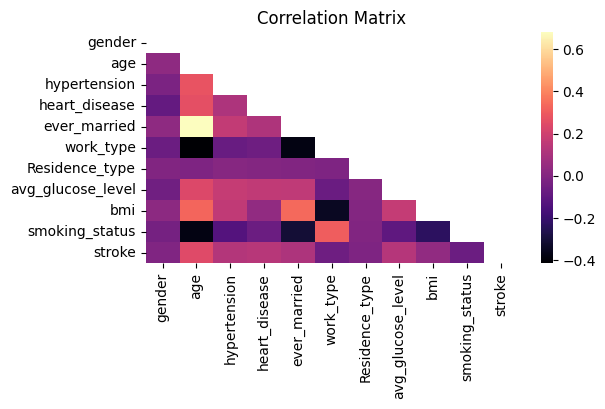

In [576]:
data_without_id = data.drop('id', axis=1)
corr_matrix = data_without_id.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  
plt.figure(figsize=(6, 3))
sb.heatmap(corr_matrix, mask=mask, annot=False, lw=0, linecolor='white', cmap='magma', fmt='0.2f')
plt.title("Correlation Matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)

corr_matrix['stroke'].sort_values(ascending=False)  

### Scatter plot of age vs bmi with highling for 'stroke' vs 'no stroke'

This plot reveals a strong correlation between age and having a stroke. Interpreting a correlation 
between stroke and BMI is challenging due to the highest concentration of stroke cases being around 
a BMI of 30. However, this outcome is as anticipated, given that the median BMI in the USA is 
approximately 29.4, as reported by [minpost](https://www.minnpost.com/second-opinion/2019/01/the-average-american-is-inching-closer-to-being-obese-cdc-data-shows/)

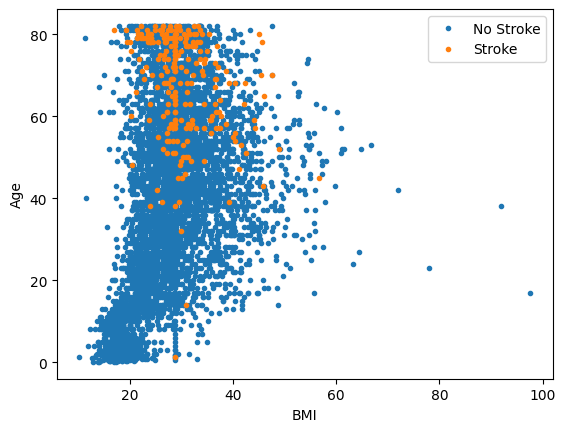

In [524]:
def plot_scatter_with_labels(X1, X2, Y, xlabel='BMI', ylabel='Age'):
  df = pd.DataFrame(dict(x1=X1, x2=X2, label=Y))
  groups = df.groupby('label')
  for number, group in groups:
    if number == 0:
      name = 'No Stroke'
    elif number == 1:
      name = 'Stroke'
    plt.plot(group.x1, group.x2, marker='o', linestyle='', ms=3, label=name)

  plt.legend()
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)

plot_scatter_with_labels(data['bmi'], data['age'], data['stroke'])

### Gender distribution of patients suffering from stroke

The plot reveals that within this dataset, there are more female patients who had a stroke, 
compared to male patients.

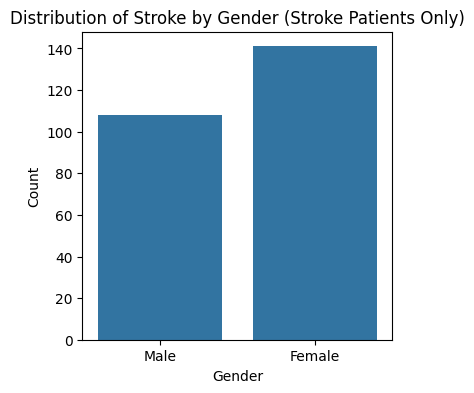

In [562]:
stroke_data = data[data['stroke'] == 1].copy()
gender_mapping = {0: 'Male', 1: 'Female', 2: 'Other'}
stroke_data['gender'] = stroke_data['gender'].map(gender_mapping)

plt.figure(figsize=(4, 4))
sb.countplot(data=stroke_data, x='gender')
plt.title('Distribution of Stroke by Gender (Stroke Patients Only)')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

### Age distribution

This plot shows that the mean age of the patients surveyed for this dataset is roughly 50 years 
old. It also reveals that the age of highest frequency amongst those surveyed is 80 years old.

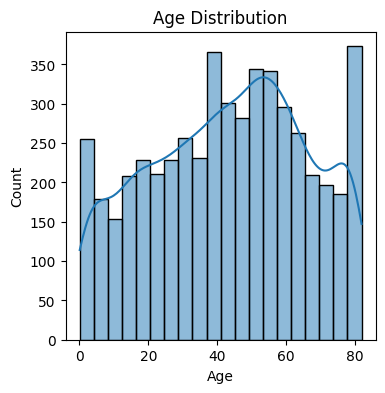

In [563]:
plt.figure(figsize=(4, 4))
sb.histplot(data['age'], bins=20, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

### Hypertension in patients with stroke

This plot reveals that the majority of patients who had a stroke did not have hypertensions.

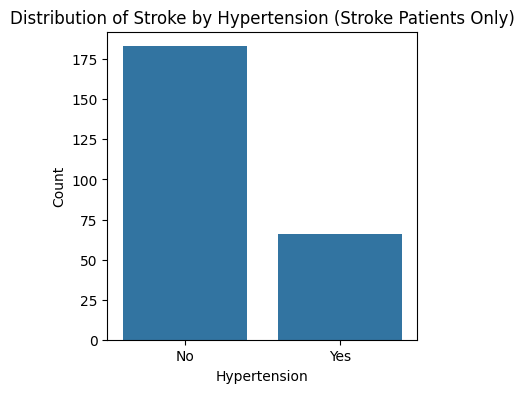

In [565]:
stroke_data = data[data['stroke'] == 1].copy()
hyper_mapping = {0: 'No', 1: 'Yes'}
stroke_data['hypertension'] = stroke_data['hypertension'].map(hyper_mapping)

plt.figure(figsize=(4, 4))
sb.countplot(data=stroke_data, x='hypertension')
plt.title('Distribution of Stroke by Hypertension (Stroke Patients Only)')
plt.xlabel('Hypertension')
plt.ylabel('Count')
plt.show()

### Heart disease in patients with stroke

This plot reveals that the majority of patients suffering from a stroke did not suffer from a 
heart disease

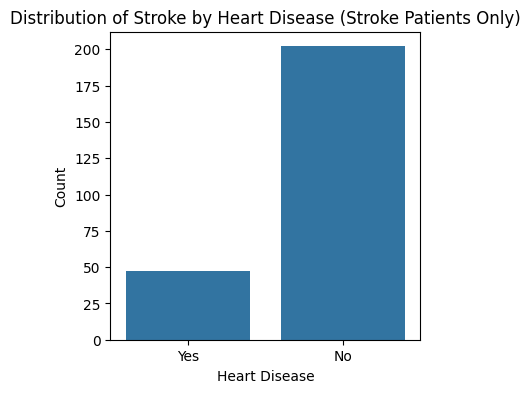

In [567]:
stroke_data = data[data['stroke'] == 1].copy()
heart_mapping = {0: 'No', 1: 'Yes'}
stroke_data['heart_disease'] = stroke_data['heart_disease'].map(heart_mapping)

plt.figure(figsize=(4, 4))
sb.countplot(data=stroke_data, x='heart_disease')
plt.title('Distribution of Stroke by Heart Disease (Stroke Patients Only)')
plt.xlabel('Heart Disease')
plt.ylabel('Count')
plt.show()

### Glucose level and stroke

This plot reveals that patients suffering from a stroke had either a low or very high glucose 
level. This can be said as the average glucose level in the USA is roughly 125 mg/dL according to 
the [Mount Sinai](https://www.mountsinai.org/health-library/tests/blood-sugar-test-blood#:~:text=Normal%20Results,mmol%2FL%29%20or%20lower.).

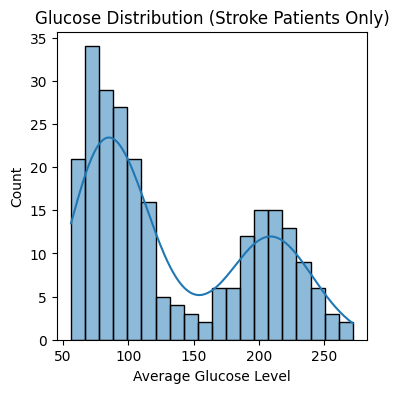

In [568]:
stroke_data = data[data['stroke'] == 1].copy()

plt.figure(figsize=(4, 4))
sb.histplot(stroke_data['avg_glucose_level'], bins=20, kde=True)
plt.title('Glucose Distribution (Stroke Patients Only)')
plt.xlabel('Average Glucose Level (mg/dL)')
plt.ylabel('Count')
plt.show()

### Smoking status distribution

This plot reveals that the greatest number of patients who suffered from a stroke have never 
smoked, however the number of people who suffered from a stroke and used to smoke is very close in
terms of count.

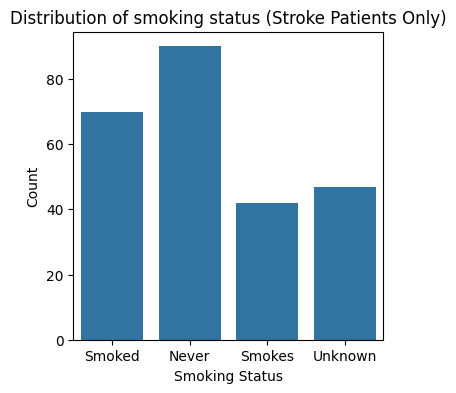

In [575]:
stroke_data = data[data['stroke'] == 1].copy()
smoke_mapping = {0:'Smoked', 1:'Never', 2:'Smokes', 3:'Unknown'}
stroke_data['smoking_status'] = stroke_data['smoking_status'].map(smoke_mapping)

plt.figure(figsize=(4, 4))
sb.countplot(data=stroke_data, x='smoking_status')
plt.title('Distribution of smoking status (Stroke Patients Only)')
plt.xlabel('Smoking Status')
plt.ylabel('Count')
plt.show()

### Stroke distribution

This plot reveals that the majority of those surveyed for this dataset did not have a stroke.

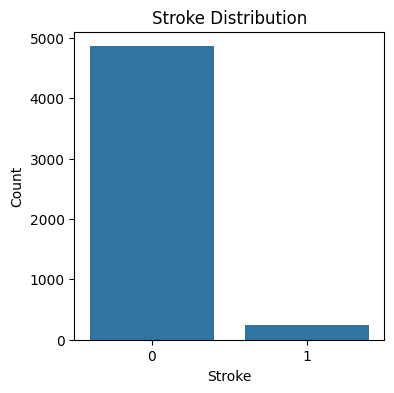

In [569]:
plt.figure(figsize=(4, 4))
sb.countplot(x='stroke', data=data)
plt.title('Stroke Distribution')
plt.xlabel('Stroke')
plt.ylabel('Count')
plt.show()

## Data pre-processing

### Feature scaling

In [531]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Covert output to numpy array and adjust shape

In [532]:
y_train = y_train.to_numpy()
y_train = y_train.ravel()
y_test = y_test.to_numpy()
y_test = y_test.ravel()

## Testing different ML models

In [533]:
avg_cv_scores = {}

### Prepare plotting function

In [534]:
def plot_prediction_results(classifier, X_train, X_test, y_train, y_test):
    # Fit the classifier on the training data
    classifier.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = classifier.predict(X_test)
    
    # Calculate the ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()
    
    # Display the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["Negative", "Positive"], rotation=45)
    plt.yticks(tick_marks, ["Negative", "Positive"])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### K-Nearst Neighbors (KNN)

[0.94987775 0.95232274 0.95232274 0.95104039 0.95471236]
Averaged prediction accuracy =  0.9520551962723663


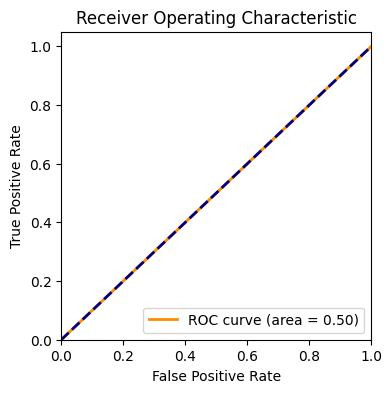

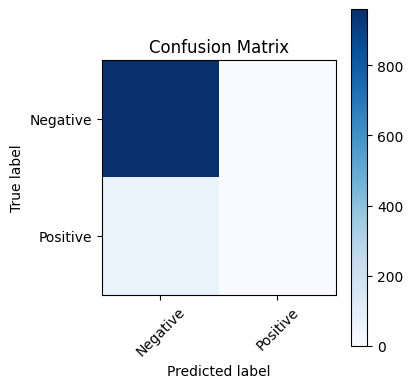

In [535]:
knn_clf = KNeighborsClassifier(n_neighbors=5) # change n_neighbors; boundary becomes smoother with increasing value of K
knn_clf.fit(X_train, y_train)
scores = cross_val_score(knn_clf, X_train, y_train, scoring='accuracy', cv=5)
print(scores)
print('Averaged prediction accuracy = ', np.average(scores))
avg_cv_scores['KNN'] = np.average(scores)
plot_prediction_results(knn_clf, X_train, X_test, y_train, y_test)

### Naive Bayes

[0.86185819 0.88753056 0.85696822 0.85067319 0.86413709]
Averaged prediction accuracy =  0.8642334499465815


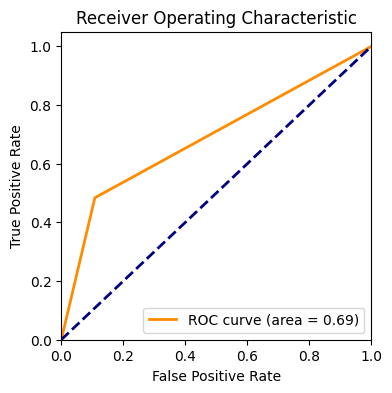

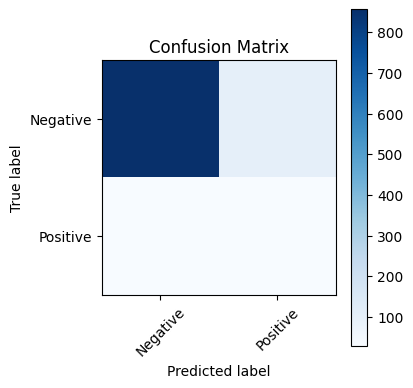

In [536]:
nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)
scores = cross_val_score(nb_clf, X_train, y_train, scoring='accuracy', cv=5)
print(scores)
print('Averaged prediction accuracy = ', np.average(scores))
avg_cv_scores['NB'] = np.average(scores)
plot_prediction_results(nb_clf, X_train, X_test, y_train, y_test)

### Tree and Forest

[0.90464548 0.92787286 0.93154034 0.93512852 0.93268054]
Averaged prediction accuracy =  0.9263735474468284


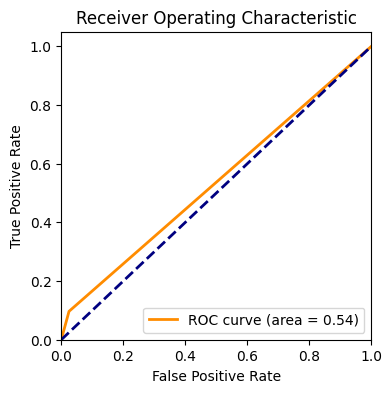

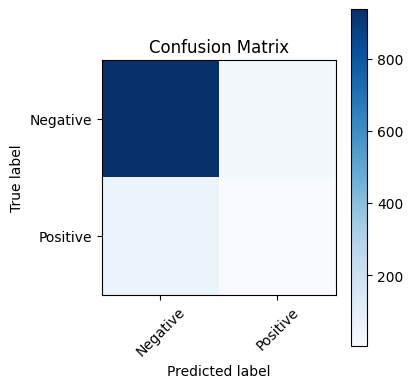

In [537]:
tree_clf = DecisionTreeClassifier(max_depth=10) # Play with hyperparameter
tree_clf.fit(X_train, y_train)
scores = cross_val_score(tree_clf, X_train, y_train, scoring='accuracy', cv=5)
print(scores)
print('Averaged prediction accuracy = ', np.average(scores))
avg_cv_scores['Decision Tree'] = np.average(scores)
plot_prediction_results(tree_clf, X_train, X_test, y_train, y_test)

### SVM-linear

[0.95476773 0.95354523 0.95354523 0.95471236 0.95471236]
Averaged prediction accuracy =  0.9542565830622498


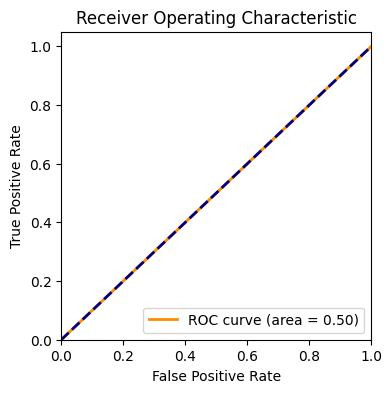

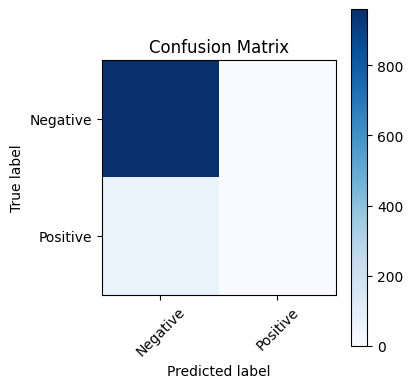

In [538]:
svmln_clf = SVC(kernel='linear')
svmln_clf.fit(X_train, y_train)
scores = cross_val_score(svmln_clf, X_train, y_train, scoring='accuracy', cv=5)
print(scores)
print('Averaged prediction accuracy = ', np.average(scores))
avg_cv_scores['SVM-linear'] = np.average(scores)
plot_prediction_results(svmln_clf, X_train, X_test, y_train, y_test)

### SVM-nonlinear (RBF and POLY kernels)

#### RBF kernel

[0.95476773 0.95354523 0.95354523 0.95471236 0.95471236]
Averaged prediction accuracy =  0.9542565830622498


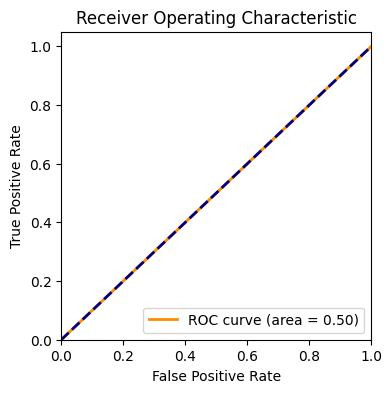

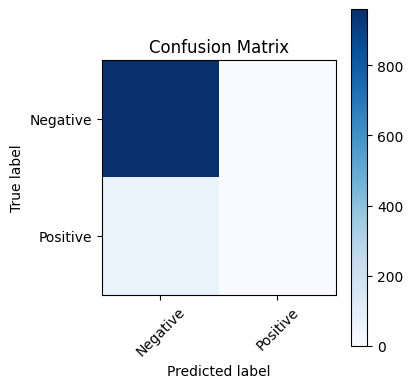

In [545]:
svmrbf_clf = SVC(kernel='rbf')
svmrbf_clf.fit(X_train, y_train)
scores = cross_val_score(svmrbf_clf, X_train, y_train, scoring='accuracy', cv=5)
print(scores)
print('Averaged prediction accuracy = ', np.average(scores))
avg_cv_scores['SVM-nonlinear-rbf'] = np.average(scores)
plot_prediction_results(svmrbf_clf, X_train, X_test, y_train, y_test)

#### POLY kernel

[0.95232274 0.95354523 0.95476773 0.95348837 0.95104039]
Averaged prediction accuracy =  0.9530328921182811


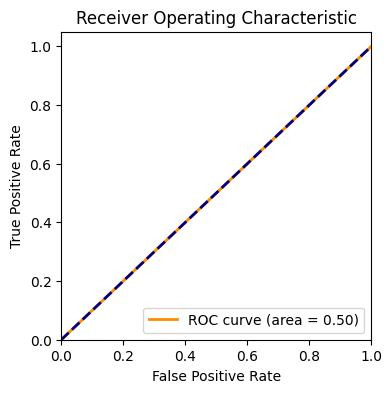

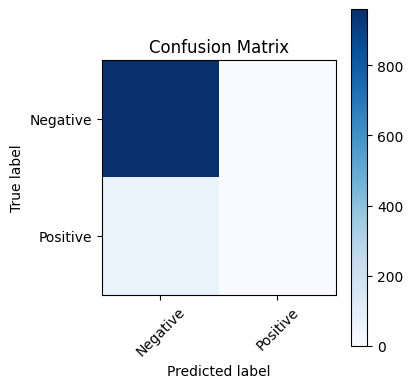

In [547]:
svmpoly_clf = SVC(kernel='poly')
svmpoly_clf.fit(X_train, y_train)
scores = cross_val_score(svmpoly_clf, X_train, y_train, scoring='accuracy', cv=5)
print(scores)
print('Averaged prediction accuracy = ', np.average(scores))
avg_cv_scores['SVM-nonlinear-poly'] = np.average(scores)
plot_prediction_results(svmpoly_clf, X_train, X_test, y_train, y_test)

## Analysis and conlusion

### Using the trained models to get predictions on the test set

In [548]:
sorted_scores = sorted(avg_cv_scores.items(), key=lambda X:X[1], reverse=True)
print(sorted_scores)

[('SVM-linear', 0.9542565830622498), ('SVM-nonlinear-rbf', 0.9542565830622498), ('SVM-nonlinear-poly', 0.9530328921182811), ('KNN', 0.9520551962723663), ('Decision Tree', 0.9263735474468284), ('NB', 0.8642334499465815)]


In [549]:
test_pred_score = {}

In [552]:
# Naive Bayes Classifier
Y_test_pred_nb = nb_clf.predict(X_test)
test_pred_score['NB'] = accuracy_score(y_test, Y_test_pred_nb)

# K-Nearst Neighbors
Y_test_pred_knn = knn_clf.predict(X_test)
test_pred_score['KNN'] = accuracy_score(y_test, Y_test_pred_knn)

# Linear SVM
Y_test_pred_svmln = svmln_clf.predict(X_test)
test_pred_score['SVM_Linear'] = accuracy_score(y_test, Y_test_pred_svmln)

# Nonlinear SVM (RBF Kernel)
Y_test_pred_svmrbf = svmrbf_clf.predict(X_test)
test_pred_score['SVM_nonlinear-rbf'] = accuracy_score(y_test, Y_test_pred_svmrbf)

# Nonlinear SVM (POLY Kernel)
Y_test_pred_svmpoly = svmpoly_clf.predict(X_test)
test_pred_score['SVM_nonlinear-poly'] = accuracy_score(y_test, Y_test_pred_svmrbf)

# Decision Tree
Y_test_pred_tree_clf = tree_clf.predict(X_test)
test_pred_score['Decision Tree'] = accuracy_score(y_test, Y_test_pred_tree_clf)

In [553]:
sorted_scores = sorted(test_pred_score.items(), key=lambda X:X[1], reverse=True)
print(sorted_scores)

[('KNN', 0.9393346379647749), ('SVM_Linear', 0.9393346379647749), ('SVM_nonlinear', 0.9393346379647749), ('SVM_nonlinear-rbf', 0.9393346379647749), ('SVM_nonlinear-poly', 0.9393346379647749), ('Decision Tree', 0.9217221135029354), ('NB', 0.8669275929549902)]


### Analysis of results

As we can see here, the KNN model performs best on the test set

### Conclusion

Conclusion

## Reference

Dataset from: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset